# Setup

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import random

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

print("CUDA dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA dostępna: True
Nazwa GPU: NVIDIA GeForce RTX 4080 SUPER


# Load and Preprocess Data

In [8]:
import os
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torch
from tqdm import tqdm

SAMPLE_RATE = 16000
NUM_SAMPLES = 16000
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512

class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, classes, split='train', transform=None):
        self.classes = classes
        self.transform = transform
        self.resampler = T.Resample(orig_freq=16000, new_freq=SAMPLE_RATE)

        val_list = self._load_list(os.path.join(root_dir, '..', 'validation_list.txt'))
        test_list = self._load_list(os.path.join(root_dir, '..', 'testing_list.txt'))

        include = set()
        exclude = set()

        if split == 'train':
            exclude = set(val_list + test_list)
        elif split == 'val':
            include = set(val_list)
        elif split == 'test':
            include = set(test_list)
        else:
            raise ValueError("split must be one of: 'train', 'val', 'test'")

        self.filepaths = []
        self.labels = []

        for label, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for file in os.listdir(cls_dir):
                if not file.endswith('.wav'):
                    continue
                rel_path = os.path.join(cls, file).replace('\\', '/')
                if (split == 'train' and rel_path in exclude) or (split in ['val', 'test'] and rel_path not in include):
                    continue
                self.filepaths.append(os.path.join(cls_dir, file))
                self.labels.append(label)

    def _load_list(self, file_path):
        if not os.path.exists(file_path):
            return []
        with open(file_path, 'r') as f:
            return [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.filepaths[idx])
        waveform = self.resampler(waveform)

        if waveform.shape[1] < NUM_SAMPLES:
            padding = (0, NUM_SAMPLES - waveform.shape[1])
            waveform = torch.nn.functional.pad(waveform, padding)
        else:
            waveform = waveform[:, :NUM_SAMPLES]

        if self.transform:
            spec = self.transform(waveform)
            spec = spec.squeeze(0)
        else:
            spec = waveform.squeeze(0)

        return spec, self.labels[idx]

mel_spectrogram = torch.nn.Sequential(
    T.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    ),
    T.AmplitudeToDB()
)

classes = ['yes', 'no', 'up', 'down']

root_audio = "./data/train/audio/"

train_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='train', transform=mel_spectrogram)
val_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='val', transform=mel_spectrogram)
test_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='test', transform=mel_spectrogram)

print(f"[LOG]: Liczba próbek treningowych: {len(train_dataset)}")
print(f"[LOG]: Liczba próbek walidacyjnych: {len(val_dataset)}")
print(f"[LOG]: Liczba próbek testowych: {len(test_dataset)}")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

[LOG]: Liczba próbek treningowych: 7398
[LOG]: Liczba próbek walidacyjnych: 1055
[LOG]: Liczba próbek testowych: 1033


### Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# Single Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Multi-head attention with residual and norm
        attn_output, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feedforward network with residual and norm
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src

# Full Transformer Encoder
class AudioTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=3, num_classes=2, dim_feedforward=256, dropout = 0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: [batch, mel, time] -> [batch, time, mel]
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # global average pooling
        return self.classifier(x)


# Train

In [10]:
def train(model, loader, optimizer, criterion, epoch, device):
    model.train()
    total_loss = 0
    correct = 0
    batch_losses = []

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val
        batch_losses.append(loss_val)

        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Train Epoch: {epoch}\tLoss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return avg_loss, acc, batch_losses


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    batch_losses = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            loss_val = loss.item()
            total_loss += loss_val
            batch_losses.append(loss_val)

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Validation: Average loss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return avg_loss, acc, batch_losses


In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns

def score_model(y_true, y_pred, model_name = "Model"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")


def training_details_plot(batch_loses_train, batch_loses_validate, title, smoothness = 0.9):
    def smooth_curve(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    train_loses = smooth_curve(batch_loses_train, smoothness)
    valid_loses = smooth_curve(batch_loses_validate, smoothness)

    plt.figure(figsize=(10, 4))
    plt.plot(train_loses, label="Train Loss")
    plt.plot(valid_loses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [12]:
import os
from collections import defaultdict


results = defaultdict(dict)
model_save_dir = "saved_transformer_models"
os.makedirs(model_save_dir, exist_ok=True)


enc_layers = [1, 3]
heads = [2, 4]
dim_FF = [128, 256]

for el in enc_layers:
    for h in heads:
        for d in dim_FF:

            config_key = f"layers{el}_heads{h}_ff{d}"
            print(f"[LOG] === Start training model: {config_key} ===")

            model = AudioTransformer(
                input_dim = N_MELS,
                d_model = 128,
                nhead = h,
                num_layers = el,
                num_classes = len(classes),
                dim_feedforward = d
            ).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)
            criterion = nn.CrossEntropyLoss()

            best_val_acc = 0
            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            model_path = os.path.join(model_save_dir, f"model_{config_key}.pth")

            epoch_nr = 0

            for epoch in range(1, 11):
                train_loss, train_acc, batch_train = train(model, train_loader, optimizer, criterion, epoch, device)
                val_loss, val_acc, batch_val = evaluate(model, val_loader, criterion, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_train)
                batch_losses_valid_all.extend(batch_val)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epoch_nr = epoch
                    torch.save(model.state_dict(), model_path)
                    print(f"[LOG] New best model saved: {model_path} (Val Acc: {val_acc:.2f}%)")
            
            results[config_key] = {
                "epoch": epoch_nr,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
                "best_val_acc": best_val_acc,
                "params": {
                    "layers": el,
                    "heads": h,
                    "ff_dim": d
                }
            }

[LOG] === Start training model: layers1_heads2_ff128 ===
Train Epoch: 1	Loss: 1.1225	Accuracy: 56.22%
Validation: Average loss: 0.8840	Accuracy: 66.64%
[LOG] New best model saved: saved_transformer_models\model_layers1_heads2_ff128.pth (Val Acc: 66.64%)
Train Epoch: 2	Loss: 0.7697	Accuracy: 71.74%
Validation: Average loss: 0.6506	Accuracy: 75.73%
[LOG] New best model saved: saved_transformer_models\model_layers1_heads2_ff128.pth (Val Acc: 75.73%)
Train Epoch: 3	Loss: 0.5865	Accuracy: 78.12%
Validation: Average loss: 0.5099	Accuracy: 80.66%
[LOG] New best model saved: saved_transformer_models\model_layers1_heads2_ff128.pth (Val Acc: 80.66%)
Train Epoch: 4	Loss: 0.4816	Accuracy: 82.25%
Validation: Average loss: 0.4453	Accuracy: 83.60%
[LOG] New best model saved: saved_transformer_models\model_layers1_heads2_ff128.pth (Val Acc: 83.60%)
Train Epoch: 5	Loss: 0.4218	Accuracy: 84.71%
Validation: Average loss: 0.4358	Accuracy: 84.83%
[LOG] New best model saved: saved_transformer_models\model_l


=== Configuration: layers1_heads2_ff128 ===


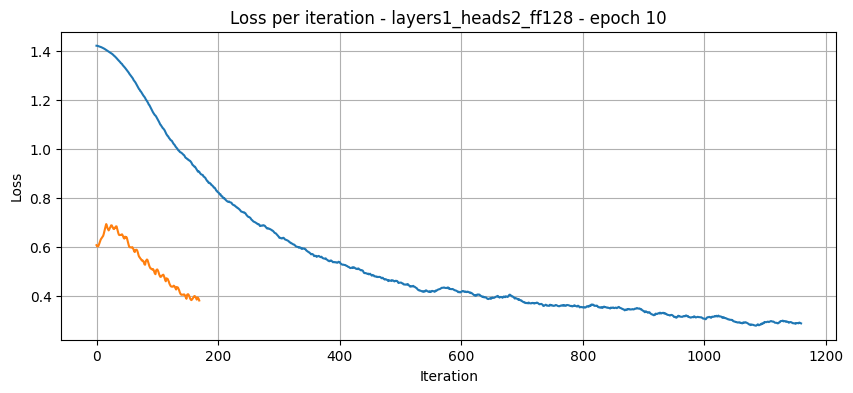

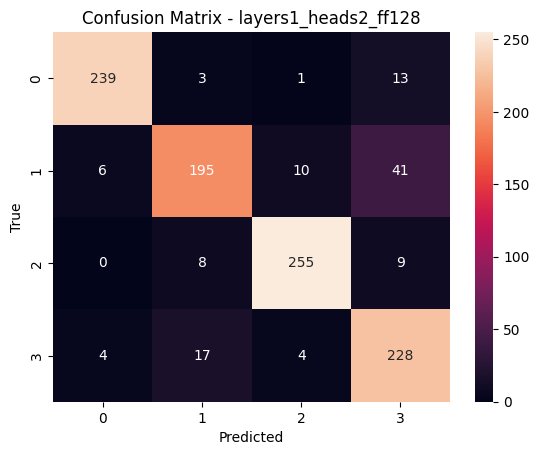

Metrics for layers1_heads2_ff128:
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       256
           1       0.87      0.77      0.82       252
           2       0.94      0.94      0.94       272
           3       0.78      0.90      0.84       253

    accuracy                           0.89      1033
   macro avg       0.89      0.89      0.89      1033
weighted avg       0.89      0.89      0.89      1033


=== Configuration: layers1_heads2_ff256 ===


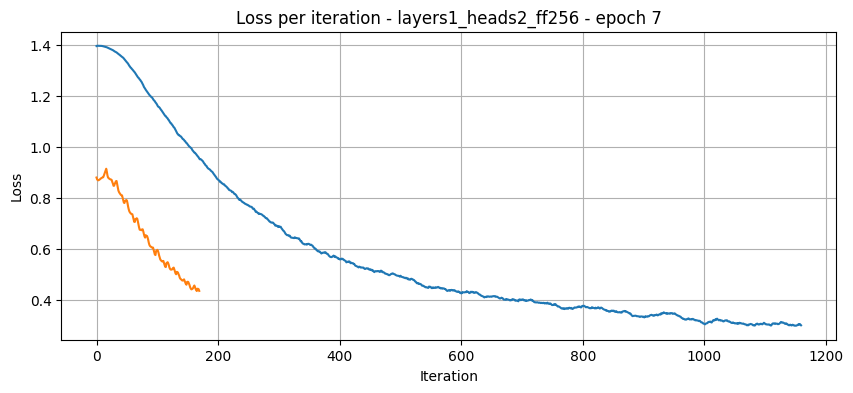

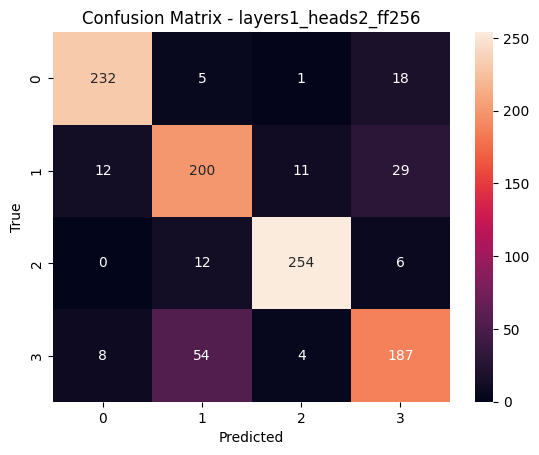

Metrics for layers1_heads2_ff256:
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       256
           1       0.74      0.79      0.76       252
           2       0.94      0.93      0.94       272
           3       0.78      0.74      0.76       253

    accuracy                           0.85      1033
   macro avg       0.84      0.84      0.84      1033
weighted avg       0.85      0.85      0.85      1033


=== Configuration: layers1_heads4_ff128 ===


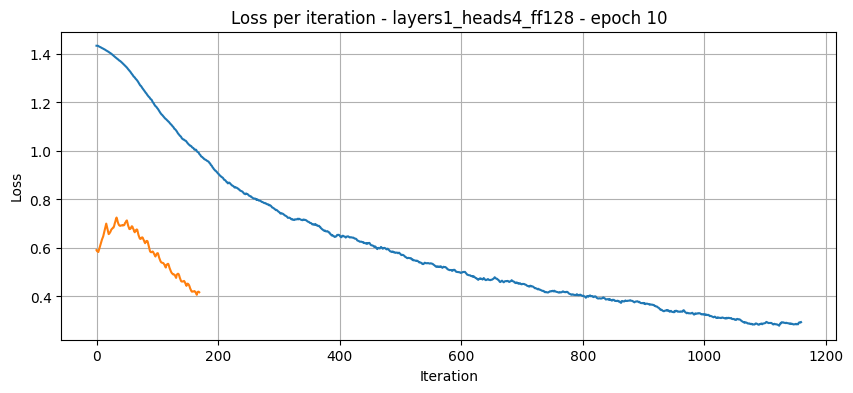

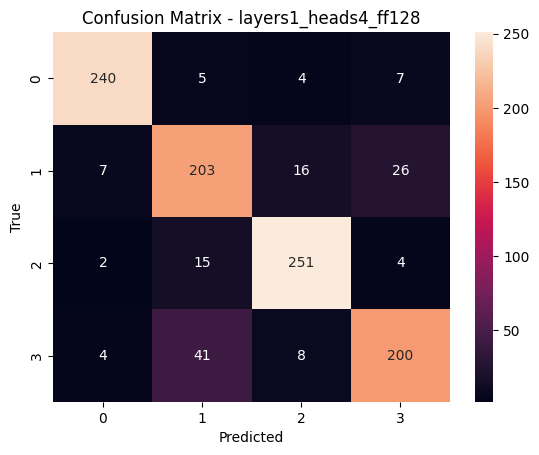

Metrics for layers1_heads4_ff128:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       256
           1       0.77      0.81      0.79       252
           2       0.90      0.92      0.91       272
           3       0.84      0.79      0.82       253

    accuracy                           0.87      1033
   macro avg       0.87      0.86      0.86      1033
weighted avg       0.87      0.87      0.87      1033


=== Configuration: layers1_heads4_ff256 ===


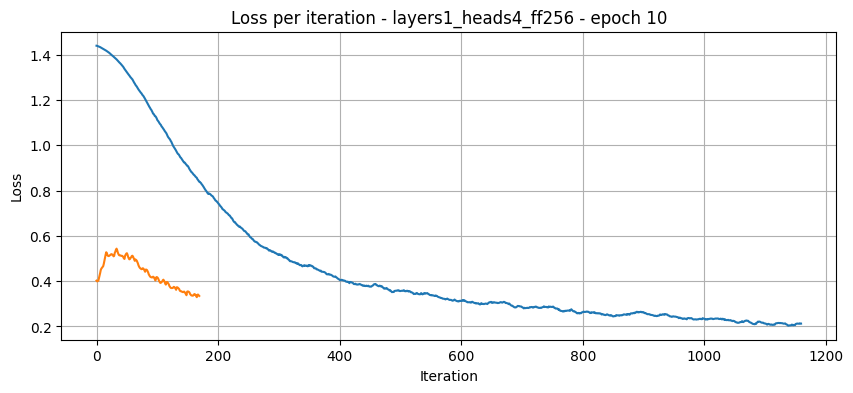

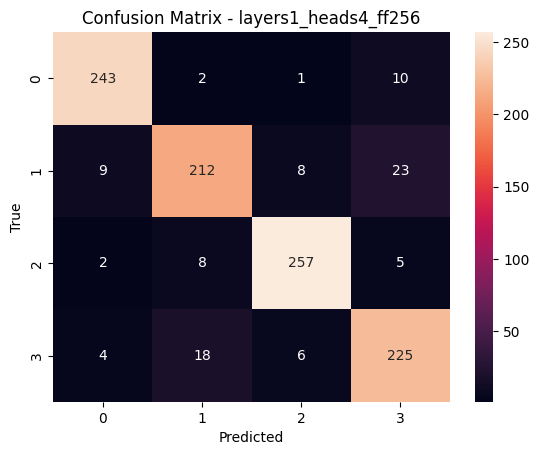

Metrics for layers1_heads4_ff256:
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       256
           1       0.88      0.84      0.86       252
           2       0.94      0.94      0.94       272
           3       0.86      0.89      0.87       253

    accuracy                           0.91      1033
   macro avg       0.91      0.91      0.91      1033
weighted avg       0.91      0.91      0.91      1033


=== Configuration: layers3_heads2_ff128 ===


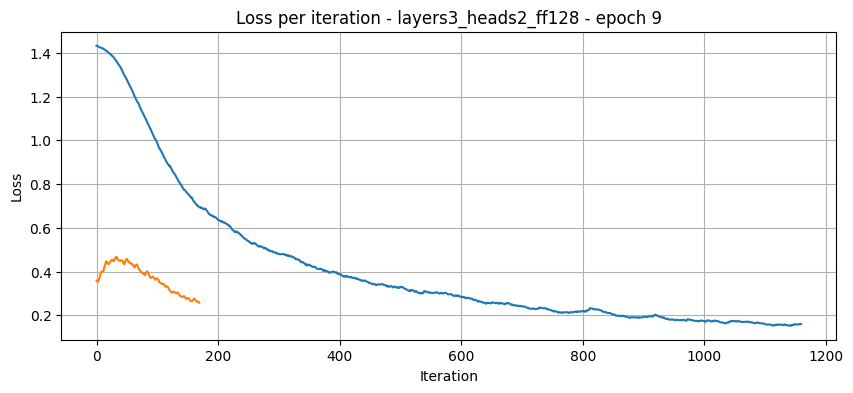

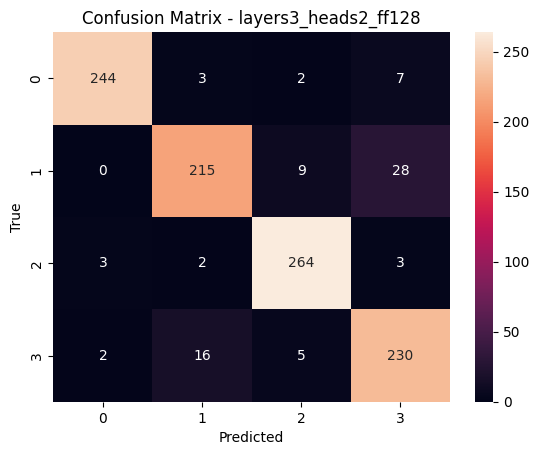

Metrics for layers3_heads2_ff128:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       256
           1       0.91      0.85      0.88       252
           2       0.94      0.97      0.96       272
           3       0.86      0.91      0.88       253

    accuracy                           0.92      1033
   macro avg       0.92      0.92      0.92      1033
weighted avg       0.92      0.92      0.92      1033


=== Configuration: layers3_heads2_ff256 ===


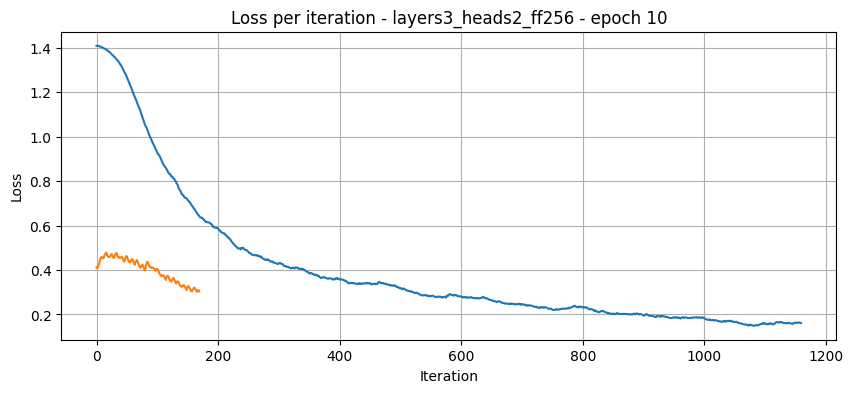

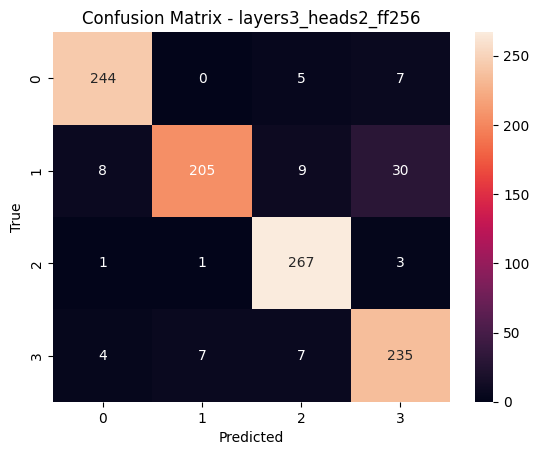

Metrics for layers3_heads2_ff256:
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       256
           1       0.96      0.81      0.88       252
           2       0.93      0.98      0.95       272
           3       0.85      0.93      0.89       253

    accuracy                           0.92      1033
   macro avg       0.92      0.92      0.92      1033
weighted avg       0.92      0.92      0.92      1033


=== Configuration: layers3_heads4_ff128 ===


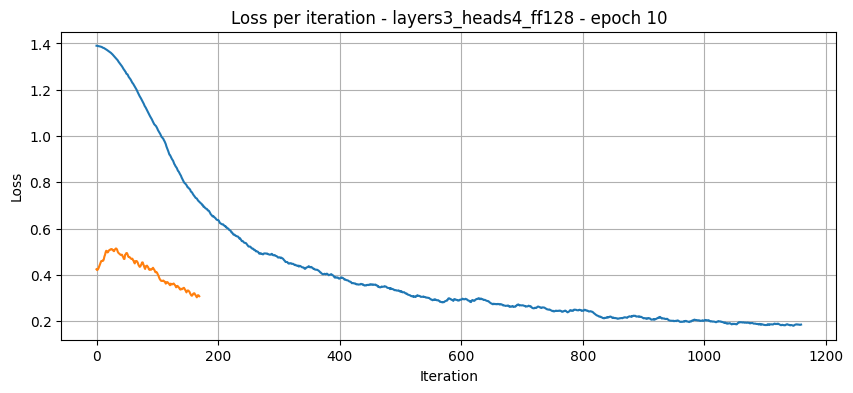

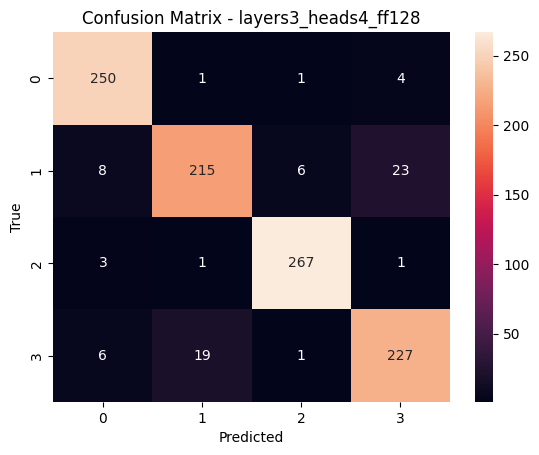

Metrics for layers3_heads4_ff128:
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       256
           1       0.91      0.85      0.88       252
           2       0.97      0.98      0.98       272
           3       0.89      0.90      0.89       253

    accuracy                           0.93      1033
   macro avg       0.93      0.93      0.93      1033
weighted avg       0.93      0.93      0.93      1033


=== Configuration: layers3_heads4_ff256 ===


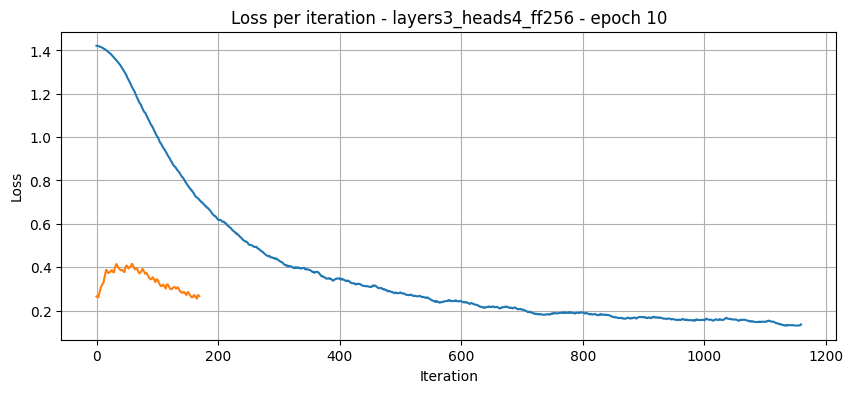

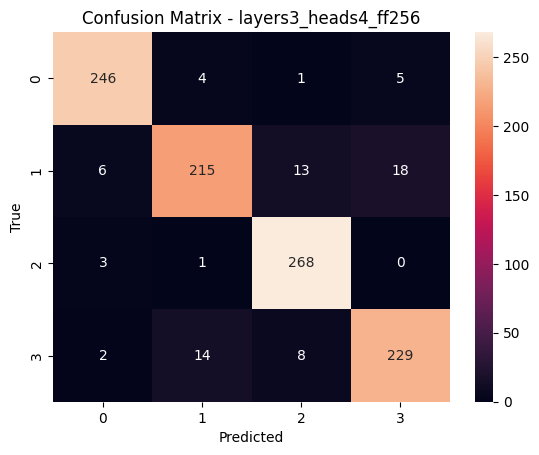

Metrics for layers3_heads4_ff256:
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       256
           1       0.92      0.85      0.88       252
           2       0.92      0.99      0.95       272
           3       0.91      0.91      0.91       253

    accuracy                           0.93      1033
   macro avg       0.93      0.93      0.93      1033
weighted avg       0.93      0.93      0.93      1033



In [13]:
for config_name, data in results.items():
        print(f"\n=== Configuration: {config_name} ===")

        # Odtwórz model
        model = AudioTransformer(
            input_dim=N_MELS,
            d_model=128,
            nhead=data["params"]["heads"],
            num_layers=data["params"]["layers"],
            num_classes=len(classes),
            dim_feedforward=data["params"]["ff_dim"]
        ).to(device)

        model.load_state_dict(torch.load(data["model_path"]))
        model.eval()

        # Rysuj loss plot
        training_details_plot(
            batch_loses_train=data["batch_losses_train"],
            batch_loses_validate=data["batch_losses_valid"],
            title=f"Loss per iteration - {config_name} - epoch {data["epoch"]}",
            smoothness=0.98
        )

        # Predykcja na zbiorze testowym
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Wyświetl metryki i confusion matrix
        score_model(all_labels, all_preds, model_name=config_name)

In [14]:
class SpeechCommandRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: [B, N_MELS, TIME] → chcemy [B, TIME, N_MELS]
        x = x.transpose(1, 2)
        output, (hidden, _) = self.lstm(x)  # hidden: [num_layers, B, hidden_size]
        out = hidden[-1]  # bierzemy wyjście z ostatniej warstwy RNN
        return self.classifier(out)


In [15]:
import os
from collections import defaultdict

# Stwórz katalog na modele
model_save_dir_rnn = "saved_rnn_models"
os.makedirs(model_save_dir_rnn, exist_ok=True)

# Wyniki
rnn_results = defaultdict(dict)

# Hiperparametry do testów
hidden_sizes = [64, 128]
num_layers_list = [2, 3]

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:

        config_key = f"hidden{hidden_size}_layers{num_layers}"
        print(f"[LOG] === Start training RNN model: {config_key} ===")

        rnn_model = SpeechCommandRNN(
            input_size=N_MELS,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=len(classes)
        ).to(device)

        optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
        criterion_rnn = nn.CrossEntropyLoss()

        best_val_acc = 0
        train_losses = []
        val_losses = []
        val_accuracies = []
        batch_losses_train_all = []
        batch_losses_valid_all = []

        model_path = os.path.join(model_save_dir_rnn, f"rnn_model_{config_key}.pth")
        epoch_nr = 0

        for epoch in range(1, 11):  # możesz dać np. 10 epok
            train_loss, train_acc, batch_train = train(rnn_model, train_loader, optimizer_rnn, criterion_rnn, epoch, device)
            val_loss, val_acc, batch_val = evaluate(rnn_model, val_loader, criterion_rnn, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            batch_losses_train_all.extend(batch_train)
            batch_losses_valid_all.extend(batch_val)

            if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epoch_nr = epoch
                    torch.save(rnn_model.state_dict(), model_path)
                    print(f"[LOG] New best RNN model saved: {model_path} (Val Acc: {val_acc:.2f}%)")

        rnn_results[config_key] = {
            "epoch": epoch_nr,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "batch_losses_train": batch_losses_train_all,
            "batch_losses_valid": batch_losses_valid_all,
            "model_path": model_path,
            "best_val_acc": best_val_acc,
            "params": {
                "hidden_size": hidden_size,
                "num_layers": num_layers
            }
        }


[LOG] === Start training RNN model: hidden64_layers2 ===
Train Epoch: 1	Loss: 1.3628	Accuracy: 35.47%
Validation: Average loss: 1.2886	Accuracy: 45.12%
[LOG] New best RNN model saved: saved_rnn_models\rnn_model_hidden64_layers2.pth (Val Acc: 45.12%)
Train Epoch: 2	Loss: 1.1293	Accuracy: 48.19%
Validation: Average loss: 0.9879	Accuracy: 56.30%
[LOG] New best RNN model saved: saved_rnn_models\rnn_model_hidden64_layers2.pth (Val Acc: 56.30%)
Train Epoch: 3	Loss: 0.9429	Accuracy: 57.39%
Validation: Average loss: 0.7944	Accuracy: 67.01%
[LOG] New best RNN model saved: saved_rnn_models\rnn_model_hidden64_layers2.pth (Val Acc: 67.01%)
Train Epoch: 4	Loss: 0.7630	Accuracy: 65.42%
Validation: Average loss: 0.6937	Accuracy: 68.34%
[LOG] New best RNN model saved: saved_rnn_models\rnn_model_hidden64_layers2.pth (Val Acc: 68.34%)
Train Epoch: 5	Loss: 0.6734	Accuracy: 68.82%
Validation: Average loss: 0.6435	Accuracy: 70.43%
[LOG] New best RNN model saved: saved_rnn_models\rnn_model_hidden64_layers2.


=== RNN Configuration: hidden64_layers2 ===


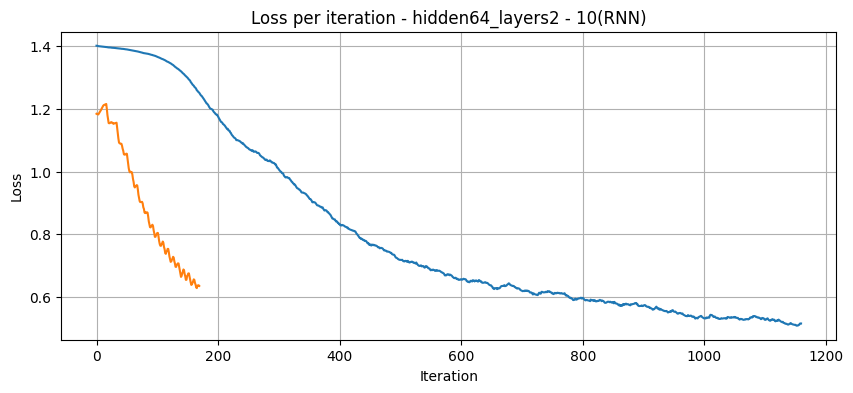

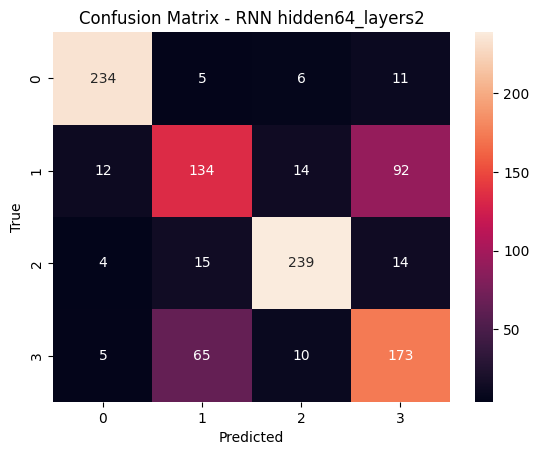

Metrics for RNN hidden64_layers2:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       256
           1       0.61      0.53      0.57       252
           2       0.89      0.88      0.88       272
           3       0.60      0.68      0.64       253

    accuracy                           0.76      1033
   macro avg       0.75      0.75      0.75      1033
weighted avg       0.76      0.76      0.75      1033


=== RNN Configuration: hidden64_layers3 ===


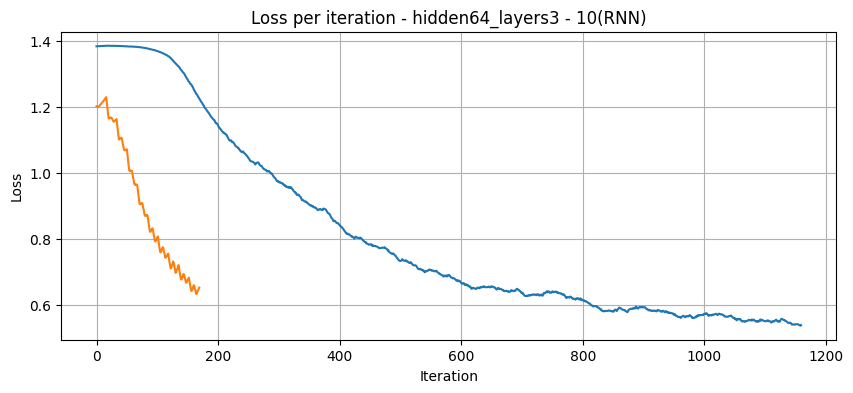

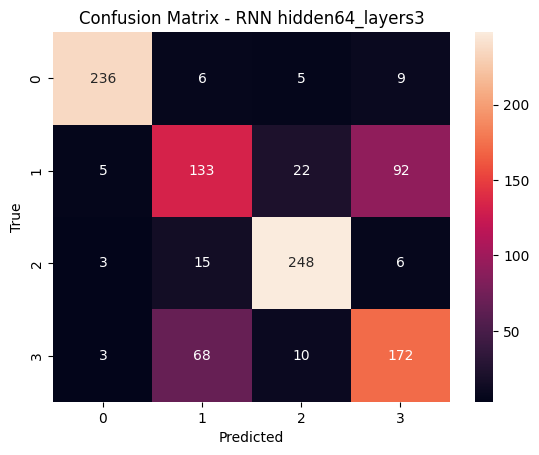

Metrics for RNN hidden64_layers3:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       256
           1       0.60      0.53      0.56       252
           2       0.87      0.91      0.89       272
           3       0.62      0.68      0.65       253

    accuracy                           0.76      1033
   macro avg       0.76      0.76      0.76      1033
weighted avg       0.76      0.76      0.76      1033


=== RNN Configuration: hidden128_layers2 ===


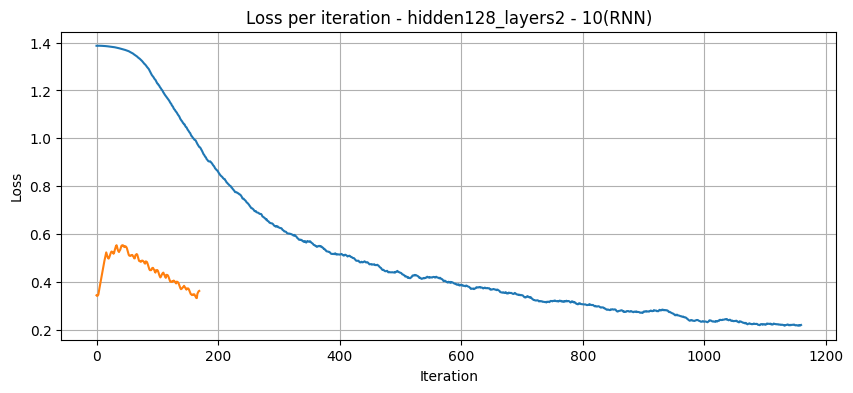

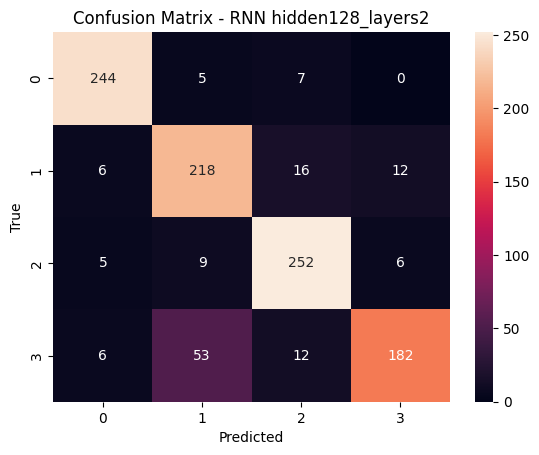

Metrics for RNN hidden128_layers2:
Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       256
           1       0.76      0.87      0.81       252
           2       0.88      0.93      0.90       272
           3       0.91      0.72      0.80       253

    accuracy                           0.87      1033
   macro avg       0.87      0.87      0.87      1033
weighted avg       0.87      0.87      0.87      1033


=== RNN Configuration: hidden128_layers3 ===


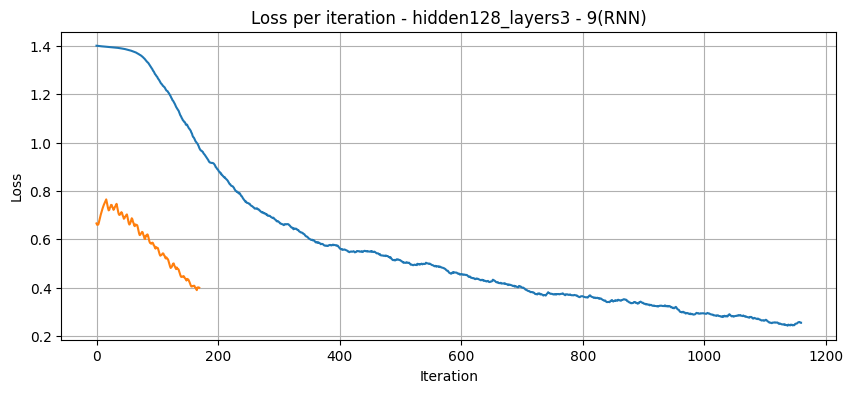

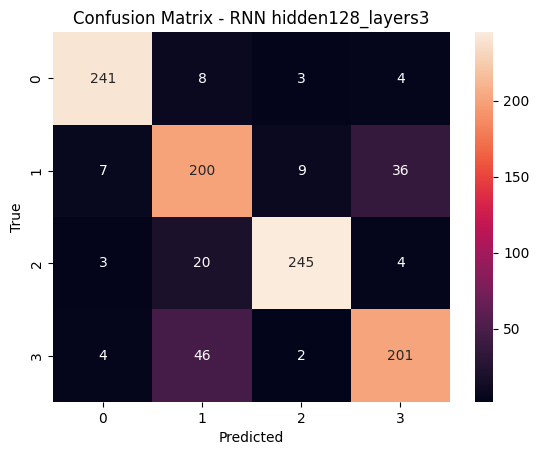

Metrics for RNN hidden128_layers3:
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       256
           1       0.73      0.79      0.76       252
           2       0.95      0.90      0.92       272
           3       0.82      0.79      0.81       253

    accuracy                           0.86      1033
   macro avg       0.86      0.86      0.86      1033
weighted avg       0.86      0.86      0.86      1033



In [16]:
for config_name, data in rnn_results.items():
    print(f"\n=== RNN Configuration: {config_name} ===")

    # Odtwórz model RNN
    model = SpeechCommandRNN(
        input_size=N_MELS,
        hidden_size=data["params"]["hidden_size"],
        num_layers=data["params"]["num_layers"],
        num_classes=len(classes)
    ).to(device)

    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()

    # Rysuj wykres lossów
    training_details_plot(
        batch_loses_train=data["batch_losses_train"],
        batch_loses_validate=data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name} - {data["epoch"]}(RNN)",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Wyświetl metryki i confusion matrix
    score_model(all_labels, all_preds, model_name=f"RNN {config_name}")


# Best model all classes

In [17]:
classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
    'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
    'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow'] #, '_background_noise_']

root_audio = "./data/train/audio/"

train_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='train', transform=mel_spectrogram)
val_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='val', transform=mel_spectrogram)
test_dataset = SpeechCommandsDataset(root_dir=root_audio, classes=classes, split='test', transform=mel_spectrogram)

print(f"[LOG]: Liczba próbek treningowych: {len(train_dataset)}")
print(f"[LOG]: Liczba próbek walidacyjnych: {len(val_dataset)}")
print(f"[LOG]: Liczba próbek testowych: {len(test_dataset)}")


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


model_save_dir = "saved_transformer_models"
os.makedirs(model_save_dir, exist_ok=True)

# This was the best model
enc_layers = 3
heads = 4
dim_FF = 256

config_key = f"layers{enc_layers}_heads{heads}_ff{dim_FF}_all_classes"
print(f"[LOG] === Start training model: {config_key} ===")

model = AudioTransformer(
    input_dim = N_MELS,
    d_model = 128,
    nhead = heads,
    num_layers = enc_layers,
    num_classes = len(classes),
    dim_feedforward = dim_FF
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
train_losses = []
val_losses = []
val_accuracies = []
batch_losses_train_all = []
batch_losses_valid_all = []

model_path = os.path.join(model_save_dir, f"model_{config_key}.pth")

for epoch in range(1, 11):
    train_loss, train_acc, batch_train = train(model, train_loader, optimizer, criterion, epoch, device)
    val_loss, val_acc, batch_val = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    batch_losses_train_all.extend(batch_train)
    batch_losses_valid_all.extend(batch_val)
    
best_val_acc = val_acc
torch.save(model.state_dict(), model_path)
print(f"[LOG] Last model saved: {model_path} (Val Acc: {val_acc:.2f}%)")

results[config_key] = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "batch_losses_train": batch_losses_train_all,
    "batch_losses_valid": batch_losses_valid_all,
    "model_path": model_path,
    "best_val_acc": best_val_acc,
    "params": {
        "layers": enc_layers,
        "heads": heads,
        "ff_dim": dim_FF
    }
}

[LOG]: Liczba próbek treningowych: 51088
[LOG]: Liczba próbek walidacyjnych: 6798
[LOG]: Liczba próbek testowych: 6835
[LOG] === Start training model: layers3_heads4_ff256_all_classes ===
Train Epoch: 1	Loss: 2.2788	Accuracy: 36.73%
Validation: Average loss: 1.3932	Accuracy: 61.99%
Train Epoch: 2	Loss: 1.0852	Accuracy: 70.01%
Validation: Average loss: 0.8883	Accuracy: 74.12%
Train Epoch: 3	Loss: 0.7702	Accuracy: 77.89%
Validation: Average loss: 0.7121	Accuracy: 79.44%
Train Epoch: 4	Loss: 0.6355	Accuracy: 81.74%
Validation: Average loss: 0.6326	Accuracy: 81.35%
Train Epoch: 5	Loss: 0.5507	Accuracy: 83.99%
Validation: Average loss: 0.6028	Accuracy: 83.04%
Train Epoch: 6	Loss: 0.4913	Accuracy: 85.68%
Validation: Average loss: 0.5320	Accuracy: 84.22%
Train Epoch: 7	Loss: 0.4450	Accuracy: 87.01%
Validation: Average loss: 0.5174	Accuracy: 84.95%
Train Epoch: 8	Loss: 0.4074	Accuracy: 88.22%
Validation: Average loss: 0.4756	Accuracy: 85.80%
Train Epoch: 9	Loss: 0.3788	Accuracy: 89.03%
Validat

### Poniżej Część twoja z CNNem

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            # Input shape: [B, 1, 128, 32]
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> [B, 32, 64, 16]
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 32, 32, 8]
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # -> [B, 64, 16, 4]
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 64, 8, 2]
            
            nn.Flatten(),
            nn.Linear(64 * 8 * 2, num_classes)  # Corrected input features
        )
    
    def forward(self, x):
        return self.net(x)
# Add mel-spectrogram transformation
mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)

# Create datasets with different transforms
cnn_dataset = SpeechCommandsDataset(
    root_dir="./data/train/audio/",
    classes=classes,
    transform=mel_spectrogram
)

# Split dataset
cnn_train_size = int(0.8 * len(cnn_dataset))
cnn_val_size = (len(cnn_dataset) - cnn_train_size) // 2
cnn_test_size = len(cnn_dataset) - cnn_train_size - cnn_val_size
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = random_split(cnn_dataset, [cnn_train_size, cnn_val_size, cnn_test_size])

# CNN DataLoader with proper collate_fn
def cnn_collate_fn(batch):
    spectrograms = torch.stack([item[0] for item in batch])  # [B, 1, N_MELS, TIME]
    labels = torch.tensor([item[1] for item in batch])
    return spectrograms.to(device), labels.to(device)

# Update DataLoaders
cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=64, 
                            shuffle=True, collate_fn=cnn_collate_fn)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=64, 
                           collate_fn=cnn_collate_fn)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=64,
                            collate_fn=cnn_collate_fn)

# Initialize CNN Model
cnn_model = SimpleCNN(num_classes=len(classes)).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Modified training/evaluation functions for CNN
def train_cnn(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}")
    
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"CNN Train Epoch: {epoch}\tLoss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return acc

def evaluate_cnn(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"CNN Validation: Loss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return acc

# Training loop for CNN
print("Training CNN Model:")
best_cnn_acc = 0
for epoch in range(1, 11):
    train_cnn(cnn_model, cnn_train_loader, cnn_optimizer, criterion, epoch)
    val_acc = evaluate_cnn(cnn_model, cnn_val_loader, criterion)
    
    if val_acc > best_cnn_acc:
        best_cnn_acc = val_acc
        torch.save(cnn_model.state_dict(), "best_cnn_model.pth")

# Evaluate CNN on test set
cnn_model.load_state_dict(torch.load("best_cnn_model.pth"))
cnn_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for data, target in cnn_test_loader:
        outputs = cnn_model(data)
        pred = outputs.argmax(dim=1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# CNN Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("CNN Confusion Matrix")
plt.show()

print(f"CNN Test Accuracy: {100 * np.mean(np.array(y_pred) == np.array(y_true)):.2f}%")

Training CNN Model:


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 64, 128, 32] to have 1 channels, but got 64 channels instead